
# Face completion with a multi-output estimators

This example shows the use of multi-output estimator to complete images.
The goal is to predict the lower half of a face given its upper half.

The first column of images shows true faces. The next columns illustrate
how extremely randomized trees, k nearest neighbors, linear
regression and ridge regression complete the lower half of those faces.


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/jovyan/scikit_learn_data


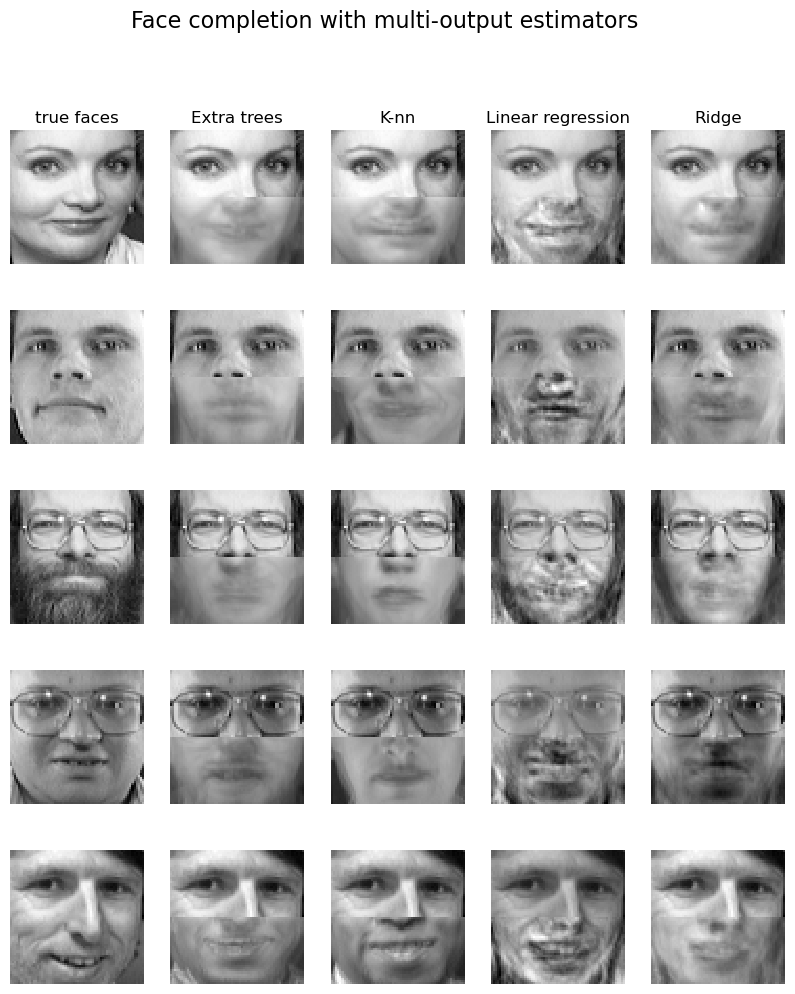

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils.validation import check_random_state
import joblib


# Load the faces datasets
data, targets = fetch_olivetti_faces(return_X_y=True)

train = data[targets < 30]
test = data[targets >= 30]  # Test on independent people

# Test on a subset of people
n_faces = 5
rng = check_random_state(4)
face_ids = rng.randint(test.shape[0], size=(n_faces,))
test = test[face_ids, :]

n_pixels = data.shape[1]
# Upper half of the faces
X_train = train[:, : (n_pixels + 1) // 2]
# Lower half of the faces
y_train = train[:, n_pixels // 2 :]
X_test = test[:, : (n_pixels + 1) // 2]
y_test = test[:, n_pixels // 2 :]

# Fit estimators
ESTIMATORS = {
    "extra-trees": ExtraTreesRegressor(
        n_estimators=10, max_features=32, random_state=0
    ),
    "k-nn": KNeighborsRegressor(),
    "linear-reg": LinearRegression(),
    "ridge": RidgeCV(),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)
    y_test_predict[name] = estimator.predict(X_test)
    joblib.dump(estimator, "faces_{}_model.pkl".format(name))

# Plot the completed faces
image_shape = (64, 64)

n_cols = 1 + len(ESTIMATORS)
plt.figure(figsize=(2.0 * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with multi-output estimators", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1, title="true faces")

    sub.axis("off")
    sub.imshow(
        true_face.reshape(image_shape), cmap=plt.cm.gray, interpolation="nearest"
    )

    for j, est in enumerate(sorted(ESTIMATORS)):
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j, title=est)

        sub.axis("off")
        sub.imshow(
            completed_face.reshape(image_shape),
            cmap=plt.cm.gray,
            interpolation="nearest",
        )

plt.show()